In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

X = np.random.rand(100, 10)
y = np.random.choice([0, 1], size=100)

df = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(X.shape[1])])
df['Target'] = y

df.head()


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Target
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073,0
1,0.020584,0.969910,0.832443,0.212339,0.181825,0.183405,0.304242,0.524756,0.431945,0.291229,1
2,0.611853,0.139494,0.292145,0.366362,0.456070,0.785176,0.199674,0.514234,0.592415,0.046450,1
3,0.607545,0.170524,0.065052,0.948886,0.965632,0.808397,0.304614,0.097672,0.684233,0.440152,1
4,0.122038,0.495177,0.034389,0.909320,0.258780,0.662522,0.311711,0.520068,0.546710,0.184854,1


In [ ]:
def chi2_feature_selection(X, y, k=5):
    chi2_scores = []

    for i in range(X.shape[1]):
        feature = X[:, i]
        observed = np.array([[(feature[y == 0] <= t).sum(), (feature[y == 1] <= t).sum()]
                             for t in np.unique(feature)])
        expected = np.outer(observed.sum(axis=1), observed.sum(axis=0)) / observed.sum()
        chi2 = ((observed - expected) ** 2 / expected).sum()
        chi2_scores.append(chi2)

    chi2_scores = np.array(chi2_scores)
    top_k_indices = np.argsort(chi2_scores)[-k:]
    return top_k_indices, chi2_scores[top_k_indices]

X_np = df.drop(columns='Target').values
y_np = df['Target'].values

selected_indices_chi2, chi2_scores = chi2_feature_selection(X_np, y_np, k=5)
selected_features_chi2 = df.columns[selected_indices_chi2]

selected_features_chi2, chi2_scores


(Index(['Feature_6', 'Feature_7', 'Feature_9', 'Feature_4', 'Feature_8'], dtype='object'),
 array([22.88567457, 25.75036032, 29.89691302, 56.64913838, 65.7854674 ]))

In [ ]:
print("Top 5 features selected by Chi-Squared:", selected_features_chi2)
print("Chi-Squared scores for these features:", chi2_scores)

Top 5 features selected by Chi-Squared: Index(['Feature_6', 'Feature_7', 'Feature_9', 'Feature_4', 'Feature_8'], dtype='object')
Chi-Squared scores for these features: [22.88567457 25.75036032 29.89691302 56.64913838 65.7854674 ]


In [ ]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
model = LogisticRegression()

rfe = RFE(model, n_features_to_select=5)

rfe = rfe.fit(X, y)

ranking = rfe.ranking_

selected_features_rfe = df.columns[np.where(ranking == 1)]

print("Selected features by RFE:", selected_features_rfe)


Selected features by RFE: Index(['Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_9'], dtype='object')


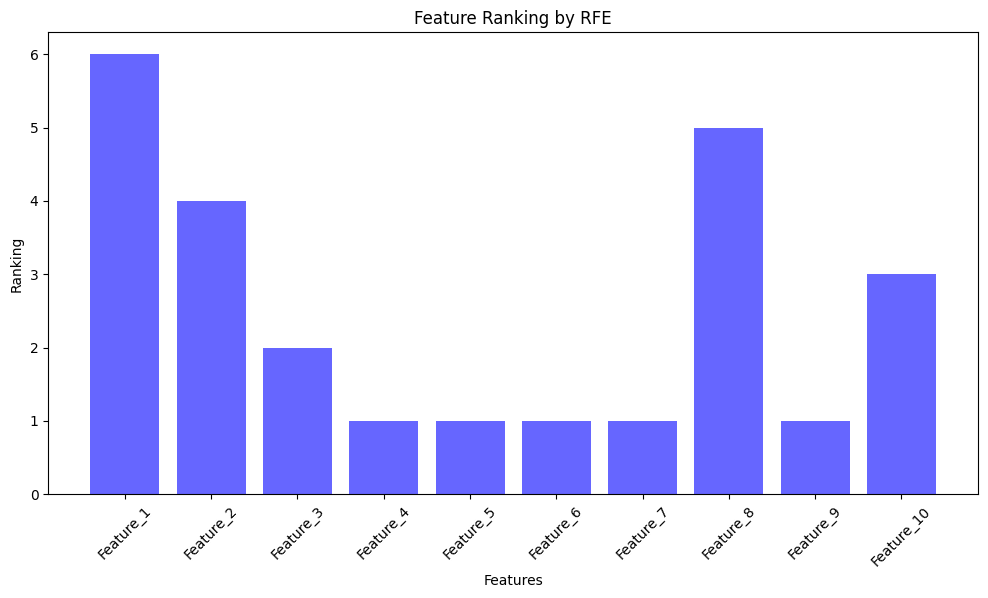

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), ranking, color='blue', alpha=0.6)
plt.xticks(range(X.shape[1]), df.columns[:-1], rotation=45)
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.title('Feature Ranking by RFE')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Train Logistic Regression on all features
model_original = LogisticRegression(max_iter=1000, random_state=42)
model_original.fit(X_train, y_train)

# Predict and evaluate
y_pred_original = model_original.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

print(f"Accuracy with all features: {accuracy_original:.4f}")


Accuracy with all features: 0.5000


In [ ]:
# Apply Recursive Feature Elimination (RFE) with Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(model, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

# Get ranking of the features and selected features
ranking = rfe.ranking_
selected_features_rfe = np.where(ranking == 1)[0]

print("Selected features by RFE:", df.columns[selected_features_rfe])

# Reduce the dataset to selected features
X_train_reduced = X_train[:, selected_features_rfe]
X_test_reduced = X_test[:, selected_features_rfe]
# Train Logistic Regression on the reduced feature set (after RFE)
model_reduced = LogisticRegression(max_iter=1000, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Predict and evaluate
y_pred_reduced = model_reduced.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

print(f"Accuracy with selected features: {accuracy_reduced:.4f}")


Selected features by RFE: Index(['Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7'], dtype='object')
Accuracy with selected features: 0.5000


In [ ]:
# Compare performance with and without feature selection
print(f"Accuracy with all features: {accuracy_original:.4f}")
print(f"Accuracy with selected features (RFE): {accuracy_reduced:.4f}")


Accuracy with all features: 0.5000
Accuracy with selected features (RFE): 0.5000


Lasso coefficients: [ 0.         -0.          0.         -0.09741943  0.02822984 -0.21052161
  0.15424302 -0.         -0.05349679  0.        ]
Selected features by Lasso: Index(['Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_9'], dtype='object')


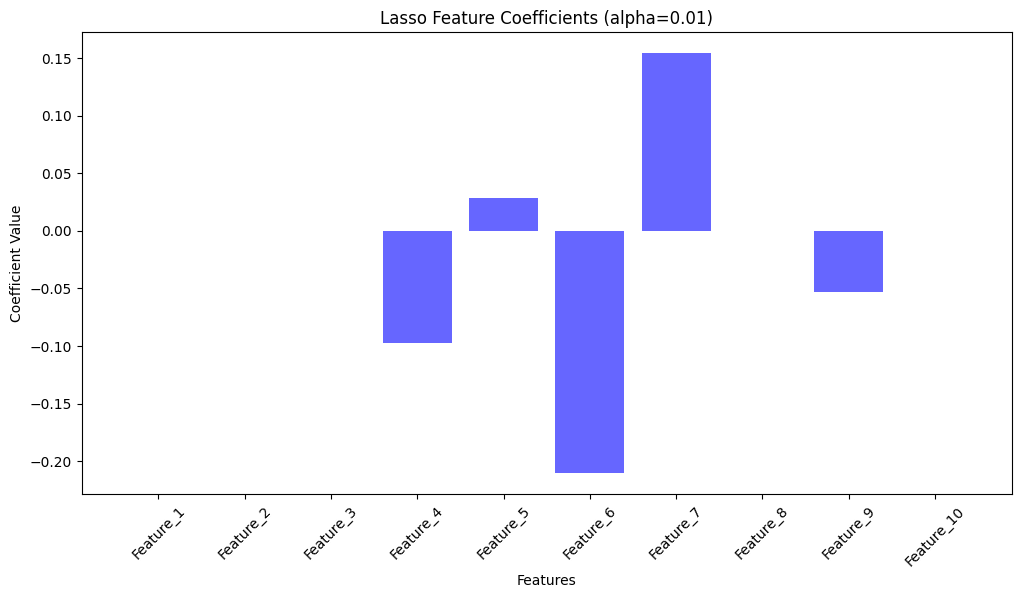

In [ ]:
from sklearn.linear_model import Lasso
alpha = 0.01
lasso = Lasso(alpha=alpha)

lasso.fit(X, y)
lasso_coefficients = lasso.coef_
selected_features_lasso = df.columns[:-1][np.where(lasso_coefficients != 0)]

print("Lasso coefficients:", lasso_coefficients)
print("Selected features by Lasso:", selected_features_lasso)

plt.figure(figsize=(12, 6))
plt.bar(range(len(lasso_coefficients)), lasso_coefficients, color='blue', alpha=0.6)
plt.xticks(range(len(lasso_coefficients)), df.columns[:-1], rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title(f'Lasso Feature Coefficients (alpha={alpha})')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Train Logistic Regression on all features
model_original = LogisticRegression(max_iter=1000, random_state=42)
model_original.fit(X_train, y_train)

# Predict and evaluate
y_pred_original = model_original.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

print(f"Accuracy with all features: {accuracy_original:.4f}")


Accuracy with all features: 0.5000


In [ ]:
# Apply Lasso for feature selection
alpha = 0.01
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)
lasso_coefficients = lasso.coef_

# Select features with non-zero coefficients
selected_features_lasso = np.where(lasso_coefficients != 0)[0]

# Reduce dataset to selected features
X_train_reduced = X_train[:, selected_features_lasso]
X_test_reduced = X_test[:, selected_features_lasso]

print("Selected features by Lasso:", df.columns[selected_features_lasso])


# Train Logistic Regression on the reduced feature set (selected by Lasso)
model_reduced = LogisticRegression(max_iter=1000, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Predict and evaluate
y_pred_reduced = model_reduced.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

print(f"Accuracy with selected features: {accuracy_reduced:.4f}")


Selected features by Lasso: Index(['Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7'], dtype='object')
Accuracy with selected features: 0.5000


In [ ]:
print(f"Accuracy with all features: {accuracy_original:.4f}")
print(f"Accuracy with selected features: {accuracy_reduced:.4f}")


Accuracy with all features: 0.5000
Accuracy with selected features: 0.5000


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

      Feature  Importance
5   Feature_6    0.143821
2   Feature_3    0.138051
4   Feature_5    0.108667
7   Feature_8    0.097635
8   Feature_9    0.097453
1   Feature_2    0.095311
9  Feature_10    0.094509
3   Feature_4    0.079215
6   Feature_7    0.073850
0   Feature_1    0.071488


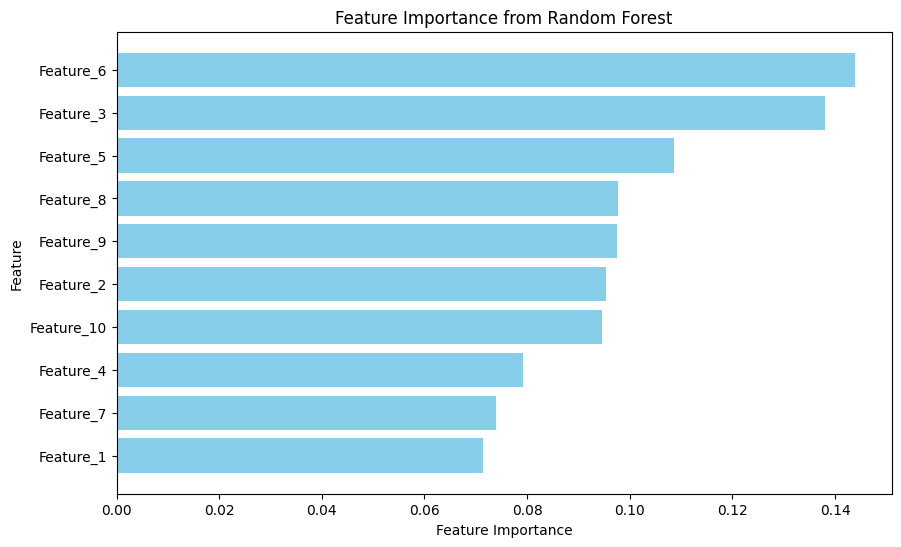

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Rank features by importance
feature_ranking = pd.DataFrame({
    'Feature': df.columns[:-1],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature ranking
print(feature_ranking)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_ranking['Feature'], feature_ranking['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Train Random Forest on the original dataset
model_original = RandomForestClassifier(n_estimators=100, random_state=42)
model_original.fit(X_train, y_train)

# Predict and evaluate
y_pred_original = model_original.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

print(f"Accuracy with all features: {accuracy_original:.4f}")


Accuracy with all features: 0.3667


In [ ]:
# Perform tree-based feature selection (using Random Forest's feature importance)
importances = model_original.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort features by importance

# Select top 5 important features
top_features = indices[:5]
X_train_reduced = X_train[:, top_features]
X_test_reduced = X_test[:, top_features]
# Train Random Forest on the reduced feature set
model_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Predict and evaluate
y_pred_reduced = model_reduced.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

print(f"Accuracy with selected features: {accuracy_reduced:.4f}")


Accuracy with selected features: 0.3333


In [ ]:
print(f"Accuracy with all features: {accuracy_original:.4f}")
print(f"Accuracy with selected features: {accuracy_reduced:.4f}")


Accuracy with all features: 0.3667
Accuracy with selected features: 0.3333
